<a href="https://colab.research.google.com/github/hannahweber244/AIPortfolio/blob/main/VAE_generative_artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import os
import numpy as np
import cv2
import copy

import torch
torch.cuda.empty_cache()


from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
#matplotlib.style.use('ggplot')

from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_color400_alt(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_color400_alt, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')
        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=6, dilation=3, stride=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,10, kernel_size=4, dilation=1, stride=3)
        self.cnn3_decode = nn.ConvTranspose2d(10,3, kernel_size=40, dilation=1, stride=5)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn3_decode(x))
        else:
            x = F.relu(self.cnn3_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

###############################
###############################
###############################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_color400(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_color400, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')
        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=10, dilation=2, stride=3, output_padding=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,25, kernel_size=7, dilation=2, stride=1)
        self.cnn3_decode = nn.ConvTranspose2d(25,50, kernel_size=10, dilation=6, stride=2, output_padding=5, padding=1)
        #stride = 2, padding=0, dil = 3, kernel =8, output=1
        self.cnn4_decode = nn.ConvTranspose2d(50,10, kernel_size=8, dilation=3, stride=2,output_padding=1, padding=0)
        #stride = 1, padding=0, dil = 9, kernel =10, output=6)
        self.cnn5_decode = nn.ConvTranspose2d(10,3, kernel_size=10, dilation=9, stride=1, padding=0, output_padding=6)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        x = F.relu(self.cnn3_decode(x))
        x = F.relu(self.cnn4_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn5_decode(x))
        else:
            x = F.relu(self.cnn5_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

#############################
#############################
#############################


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_grey400(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_grey400, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')

        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=6, dilation=3, stride=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,10, kernel_size=4, dilation=1, stride=3)
        self.cnn3_decode = nn.ConvTranspose2d(10,1, kernel_size=40, dilation=1, stride=5)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn3_decode(x))
        else:
            x = F.relu(self.cnn3_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std


In [ ]:
class VAE_Pipeline400(object):

    def __init__(self, path_images, lr=0.0005, num_epochs = 100, batch_size = 64, color = True):

        #generelle informationen fürs training und zu den daten
        self.path = path_images
        self.epochs = num_epochs
        self.lr = lr
        self.color = color
        self.batch_size = batch_size

        #modell, optimierer und lossfunction platzhalter
        self.model = None
        self.optimizer = None
        self.criterion = None

        #log fü den trainingsloss
        self.loss_log = pd.DataFrame(columns = ['epoche', 'loss'])
        self.reconstruction = dict()


        #listen, die bilder und batches mit bildern enthalten
        self.data = list()
        self.batches = list()

        #funktionen zum einlesen der bilder, erzeugen von batches und
        #trainieren des modells aufrufen, danach kann gernerate funktion der 
        #klasse aufgerufen und neue bilder erzeugt werden
        self.load_images()
        self.create_batches()
        self.train_model()

    def load_images(self):
        images = os.listdir(self.path)
        for i, image in tqdm(enumerate(images)):
            img_path = os.path.join(self.path, image)
            if self.color:
                img = cv2.imread(img_path, 1)
            else:
                img = cv2.imread(img_path, 0)
            #bilder auf einheitliche größe bringen
            img = cv2.resize(img, (400,400))
            self.data.append(img)

    def create_batches(self):
        batch = list()
        random.shuffle(self.data)
        for k, d_  in enumerate(self.data[:200], start = 1):
            if k % self.batch_size == 0:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)#color diemension is last dimension, but needs to be first dimension --> permute
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)
                batch = torch.stack(batch)
                self.batches.append(batch)
                batch = list()
            else:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)

        if len(batch) > 0:
            batch = torch.stack(batch)
            self.batches.append(batch)
            batch = list()

    def final_loss(self, bce_loss, mu, logvar):
        """
        This function will add the reconstruction loss (BCELoss) and the 
        KL-Divergence.
        KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        :param bce_loss: recontruction loss
        :param mu: the mean from the latent vector
        :param logvar: log variance from the latent vector
        """
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def train(self):
        self.model.train()
        running_loss = 0
        key = list(self.reconstruction.keys())[-1]
        for batch_id, batch in enumerate(self.batches):
            self.optimizer.zero_grad()
            out, mu, std = self.model(batch.float())
            self.reconstruction[key].append((batch, out))
            bce_loss = self.criterion(out, batch.float())
            loss = self.final_loss(bce_loss, mu, std)
            running_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            if batch_id % 10 == 0:
                print(f"Fortschritt: {batch_id/len(self.batches)*100}% finished")
        avg_loss = running_loss/len(self.batches)
        return avg_loss

    def train_model(self):
        if self.color:
            self.model = ImageVAE_color400(sigmoid = False).to(device)
        else:
            self.model = ImageVAE_grey400(sigmoid = False).to(device)
        lr = self.lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #wenn logits loss verwendet wird kein sigmoid layer, aber target sollt in [0,1] liegen
        self.criterion = nn.BCEWithLogitsLoss(reduction='sum')
        print(self.model)
        for epoch in range(self.epochs):
            print('epoche:', epoch+1)
            self.reconstruction[epoch] = list()
            train_loss = self.train()
            self.loss_log.loc[len(self.loss_log), :] = [epoch+1, train_loss]

    def generate_images(self, num_images, emb_size = 5, color = False, norm = False):
        for i in range(num_images):
            tensor = torch.zeros(emb_size)
            print(tensor.shape)
            prefix = 'normalized_'
            if not norm:
                prefix = 'random_'
                for k in range(tensor.shape[0]):
                    z = random.randint(-100,10)
                    tensor[k] = z
                tensor = tensor.float().to(device)*torch.randn_like(torch.zeros(emb_size)).to(device)
            else:
                tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
            #tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
            self.model.batch_size = 1
            img = self.model.decode_convolutions(tensor).cpu()
            if self.color:
                img = img.permute(0,2,3,1).detach().numpy()[0]*255
            else:
                img = img.detach().numpy()[0][0]*255
            #print(img.shape)
            cv2_imshow(img)
            #plt.figure()
            #plt.imshow(img/255)
            #img[:, :, 0] = 0
            #img[:, :, 2] = 0
            #cv2_imshow(img)
            #folder = '/content/drive/My Drive/ImageGeneration/generated_images'
            #file_name = prefix+str(i)+'_epoche_20_400400_ersteVersion_withlogitsloss_neueVersion.png'
            #if not os.path.exists(folder):
            #    os.mkdir(folder)
            #cv2.imwrite(os.path.join(folder, file_name), img)
            print('latent vector:', tensor)

In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
van_path = os.path.join(path, artists[0])
print(van_path)
vanGogh = VAE_Pipeline400(van_path, num_epochs = 55)
vanGogh.generate_images(15, color=True)

/content/drive/My Drive/ImageGeneration/artists/Vincent_van_Gogh



please use BCEWithLogitsLoss as criterion
ImageVAE_color400(
  (pool_1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=6, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(3, 10, kernel_size=(10, 10), stride=(2, 2))
  (cnn2): Conv2d(10, 5, kernel_size=(8, 8), stride=(3, 3))
  (cnn3): Conv2d(5, 1, kernel_size=(5, 5), stride=(2, 2))
  (encode): Linear(in_features=25, out_features=10, bias=True)
  (decode): Linear(in_features=5, out_features=25, bias=True)
  (cnn1_decode): ConvTranspose2d(1, 5, kernel_size=(10, 10), stride=(3, 3), dilation=(2, 2), output_padding=(2, 2))
  (cnn2_decode): ConvTranspose2d(5, 25, kernel_size=(7, 7), stride=(1, 1), dilation=(2, 2))
  (cnn3_decode): ConvTranspose2d(25, 50, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1), dilation=(6, 6), output_padding=(5, 5))
  (cnn4_decode): ConvTranspose2d

RuntimeError: ignored

In [ ]:
for epoche, tup_list in vanGogh.reconstruction.items():
    print('epoche:', epoche)
    for original, reconstructed in tup_list:

        orig_ = original[0].cpu().permute(1,2,0).detach().numpy()*255
        recons_ = reconstructed[0].cpu().permute(1,2,0).detach().numpy()*255
        print('original')
        cv2_imshow(orig_)
        print('reconstructed')
        cv2_imshow(recons_)
        break

torch.Size([5])


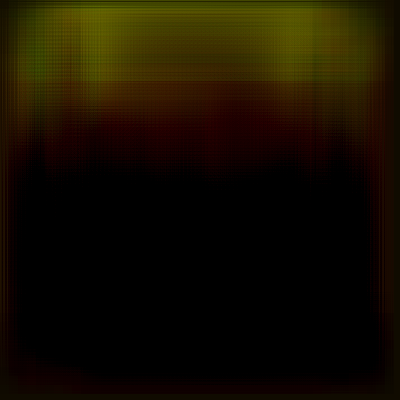

latent vector: tensor([ 0.7931,  0.2937,  0.3813,  0.9573, -1.1447], device='cuda:0')
torch.Size([5])


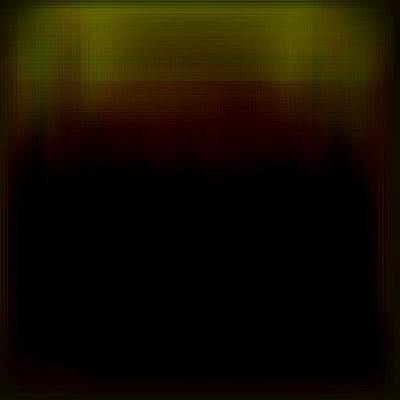

latent vector: tensor([-0.4322, -1.0356, -0.5897, -1.2734, -0.5152], device='cuda:0')
torch.Size([5])


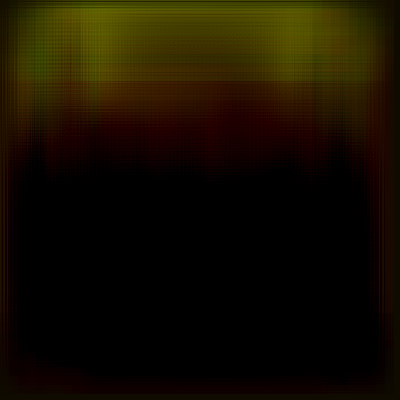

latent vector: tensor([ 1.1863,  0.0421,  0.0059, -1.5978,  0.2231], device='cuda:0')
torch.Size([5])


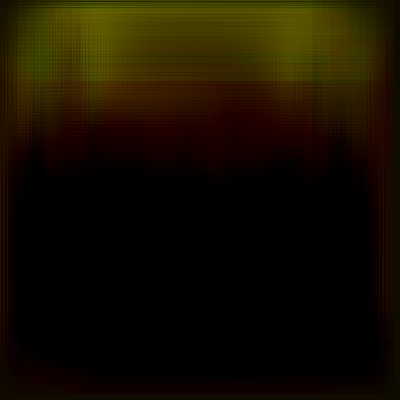

latent vector: tensor([-0.9516, -0.9393,  2.1364, -1.6248,  1.6930], device='cuda:0')
torch.Size([5])


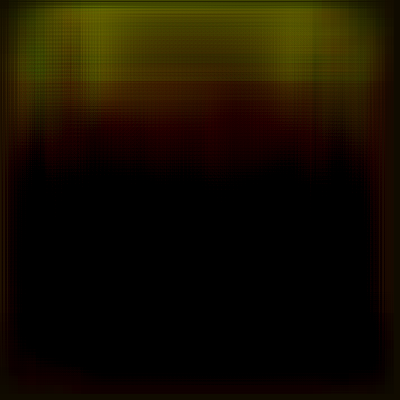

latent vector: tensor([ 1.3882,  1.6012, -0.2253,  0.5103, -0.4019], device='cuda:0')
torch.Size([5])


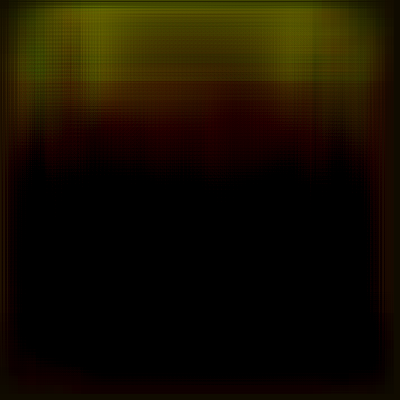

latent vector: tensor([-0.0626,  1.9161, -0.7182,  0.1060, -0.9702], device='cuda:0')
torch.Size([5])


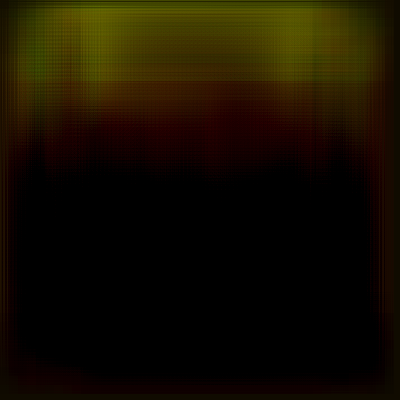

latent vector: tensor([ 0.8855, -0.4503, -1.7349,  1.0166,  0.1653], device='cuda:0')
torch.Size([5])


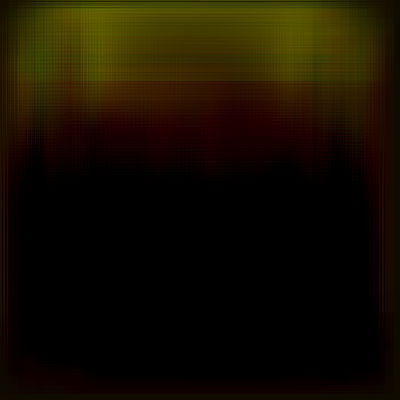

latent vector: tensor([-0.3901, -2.0769, -0.9891,  1.5251, -0.2983], device='cuda:0')
torch.Size([5])


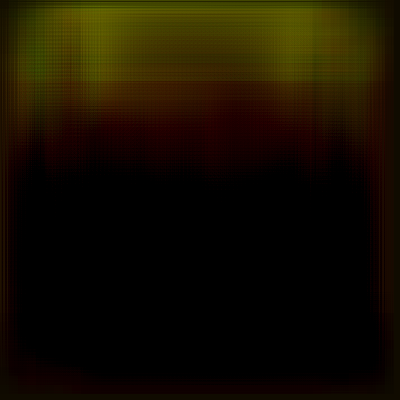

latent vector: tensor([-0.2622,  1.9922,  1.6962,  0.4384, -0.4033], device='cuda:0')
torch.Size([5])


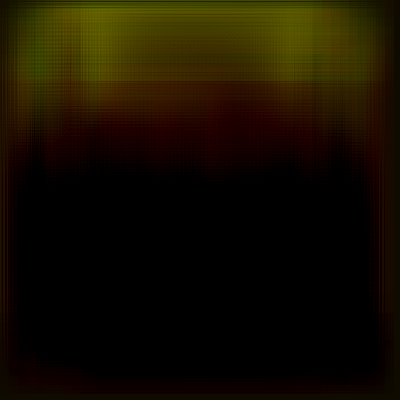

latent vector: tensor([-1.5510,  0.3370,  1.3142,  0.5246, -0.2772], device='cuda:0')
torch.Size([5])


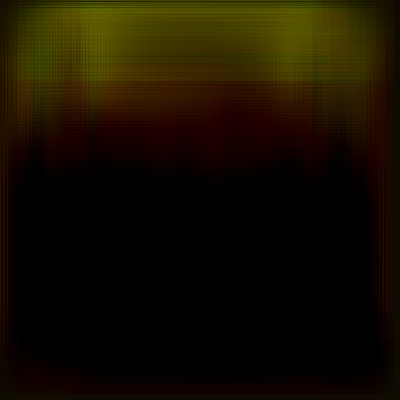

latent vector: tensor([ 1.5252, -2.2631,  1.4376,  0.3427,  1.0065], device='cuda:0')
torch.Size([5])


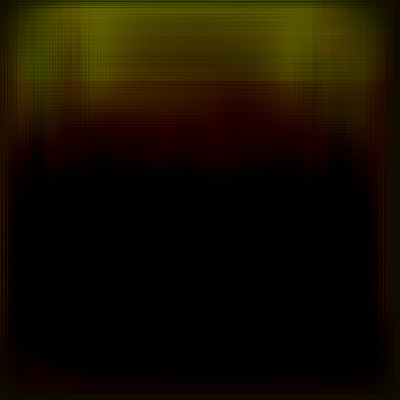

latent vector: tensor([ 0.3749,  0.1125,  1.5637, -1.9566, -0.2186], device='cuda:0')
torch.Size([5])


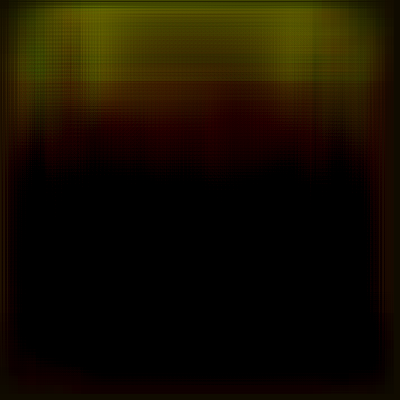

latent vector: tensor([ 1.1468,  0.4748, -0.7677, -0.2920, -1.8053], device='cuda:0')
torch.Size([5])


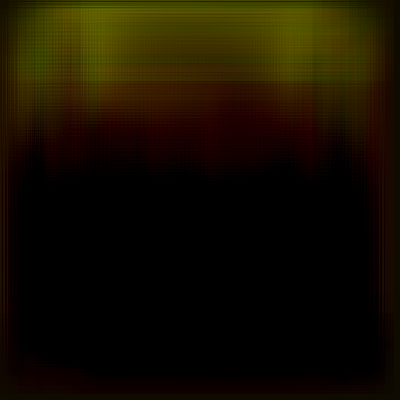

latent vector: tensor([-1.3729, -1.1423,  0.9737, -0.6691,  0.1410], device='cuda:0')
torch.Size([5])


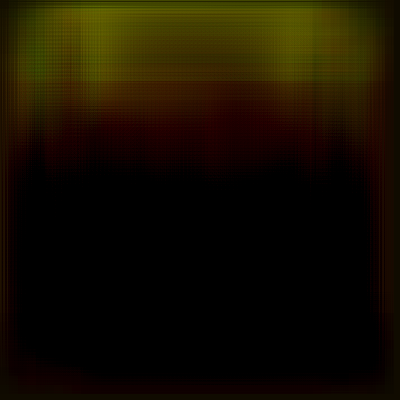

latent vector: tensor([ 0.5704,  0.1235, -1.6513, -0.6352, -0.0485], device='cuda:0')


In [ ]:
vanGogh.generate_images(15, color=True, norm = True)

/content/drive/My Drive/ImageGeneration/artists/Vincent_van_Gogh



please use BCEWithLogitsLoss as criterion
ImageVAE_grey400(
  (pool_1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=6, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(1, 10, kernel_size=(10, 10), stride=(2, 2))
  (cnn2): Conv2d(10, 5, kernel_size=(8, 8), stride=(3, 3))
  (cnn3): Conv2d(5, 1, kernel_size=(5, 5), stride=(2, 2))
  (encode): Linear(in_features=25, out_features=10, bias=True)
  (decode): Linear(in_features=5, out_features=25, bias=True)
  (cnn1_decode): ConvTranspose2d(1, 5, kernel_size=(6, 6), stride=(2, 2), dilation=(3, 3))
  (cnn2_decode): ConvTranspose2d(5, 10, kernel_size=(4, 4), stride=(3, 3))
  (cnn3_decode): ConvTranspose2d(10, 1, kernel_size=(40, 40), stride=(5, 5))
  (mean): Linear(in_features=10, out_features=5, bias=True)
  (log_var): Linear(in_features=10, out_features=5, bias=True)
)
epoche:

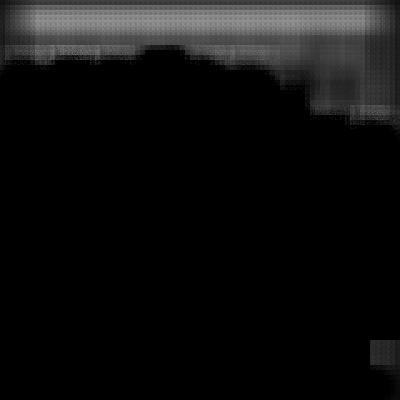

latent vector: tensor([  14.1958,   41.5602,  -18.1004,   -7.7222, -134.8876],
       device='cuda:0')
torch.Size([5])


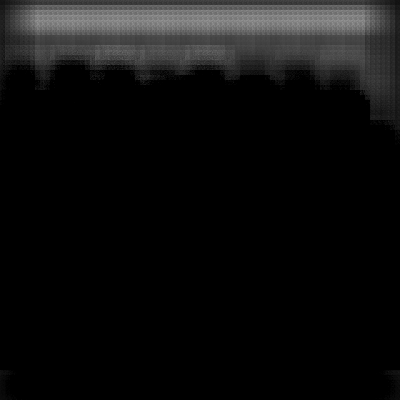

latent vector: tensor([-28.3225,  -3.7030, -82.7330, -15.3095, -21.5471], device='cuda:0')
torch.Size([5])


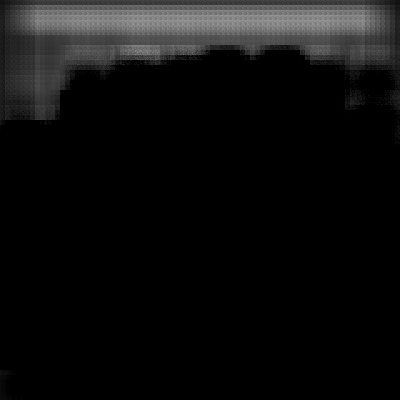

latent vector: tensor([ 36.2413,   5.0159,  -3.8410, -47.9489, 169.5442], device='cuda:0')
torch.Size([5])


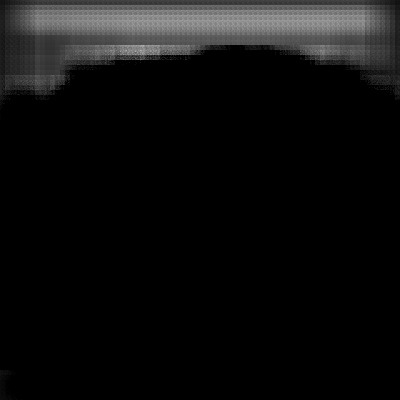

latent vector: tensor([-57.2136,   2.8679,   6.5428,  64.1303, 131.8428], device='cuda:0')
torch.Size([5])


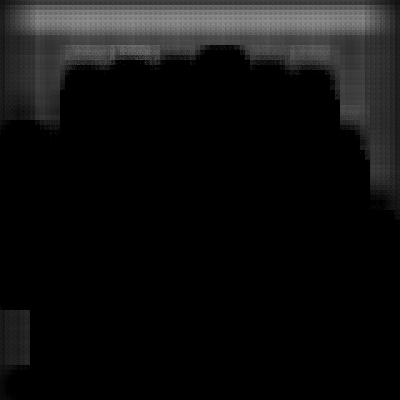

latent vector: tensor([ 43.7786, -51.0813,  43.7717,  98.6647,   8.2031], device='cuda:0')
torch.Size([5])


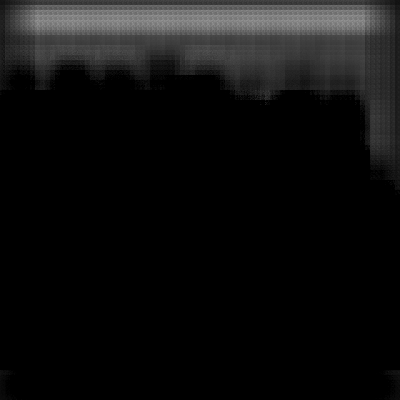

latent vector: tensor([ 14.2145,   4.0711, -32.4591,   9.9275,  -8.9153], device='cuda:0')
torch.Size([5])


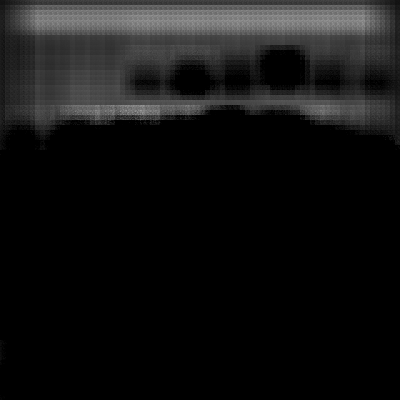

latent vector: tensor([ 67.4084,  23.4824,   5.8828, -81.4774,  63.8742], device='cuda:0')
torch.Size([5])


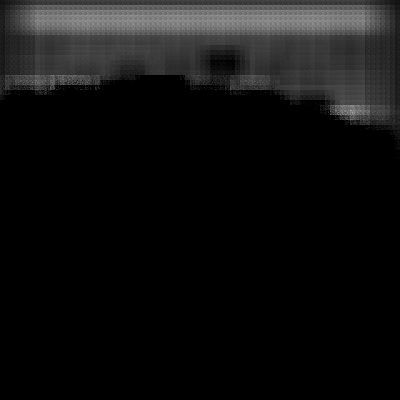

latent vector: tensor([ 78.7059,  75.9851, 117.8412,  32.5406,   1.4130], device='cuda:0')
torch.Size([5])


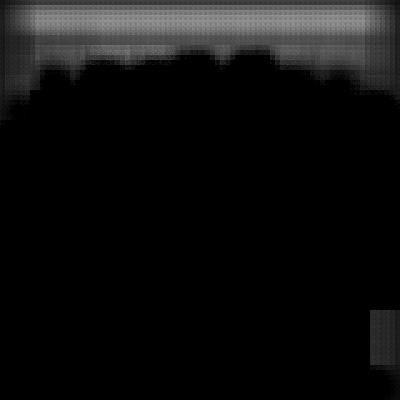

latent vector: tensor([-70.0619,   0.8359,  10.2385,   5.5879,   6.2198], device='cuda:0')
torch.Size([5])


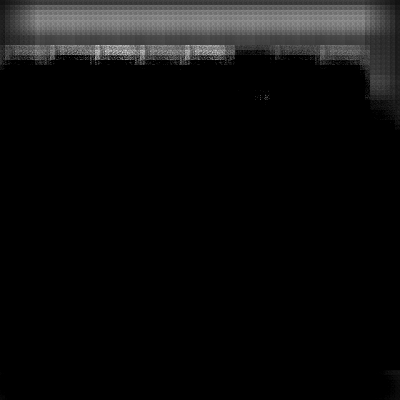

latent vector: tensor([  46.3067,  190.7391, -166.1292,    8.8367,   -2.0070],
       device='cuda:0')
torch.Size([5])


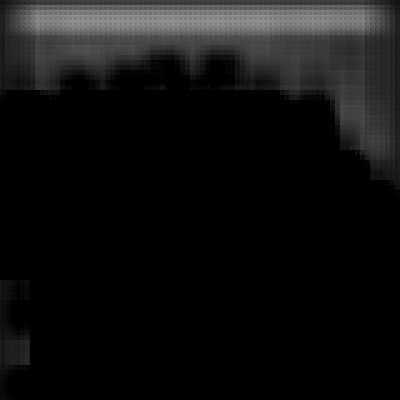

latent vector: tensor([ 58.7050, -10.5995,   0.5954,   7.0674,  -3.2548], device='cuda:0')
torch.Size([5])


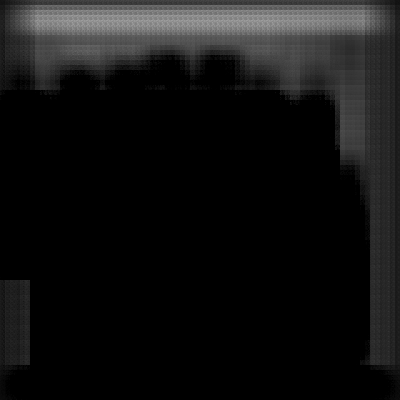

latent vector: tensor([ 18.4790, -31.2259,  23.5357,  47.0526, -40.6492], device='cuda:0')
torch.Size([5])


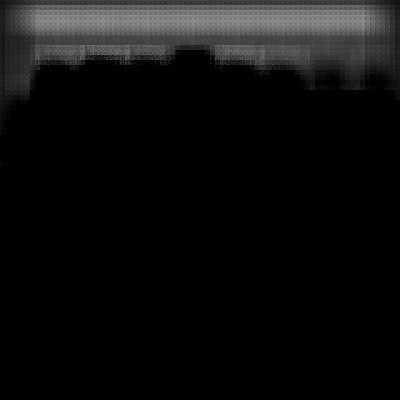

latent vector: tensor([-18.9988,  -7.6771,  76.5276, -54.1599,  -4.1118], device='cuda:0')
torch.Size([5])


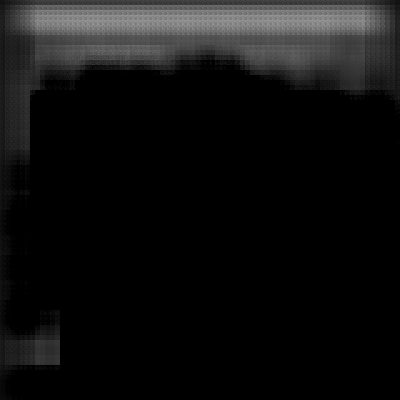

latent vector: tensor([  8.9584, -83.6019,  -4.6446, -26.5365,  -1.6994], device='cuda:0')
torch.Size([5])


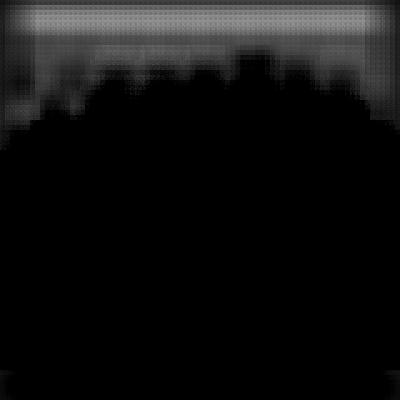

latent vector: tensor([-39.5121,  23.6645, -55.7390, -36.0474,  -1.1589], device='cuda:0')


In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
van_path = os.path.join(path, artists[0])
print(van_path)
vanGogh = VAE_Pipeline400(van_path, num_epochs = 10, color = False)
vanGogh.generate_images(15, color=True)

torch.Size([5])


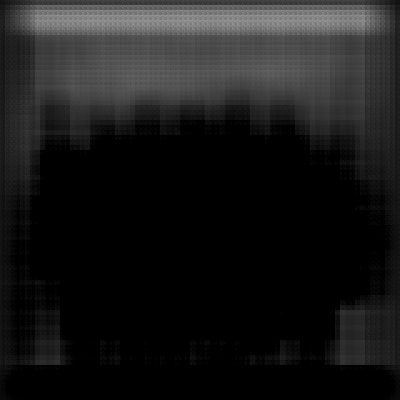

latent vector: tensor([-2.1289, -1.8412,  0.0294, -1.0890,  0.3642], device='cuda:0')
torch.Size([5])


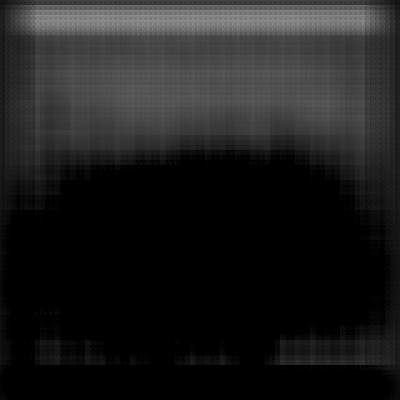

latent vector: tensor([-0.5414,  0.8976,  0.7030, -0.5975,  0.1939], device='cuda:0')
torch.Size([5])


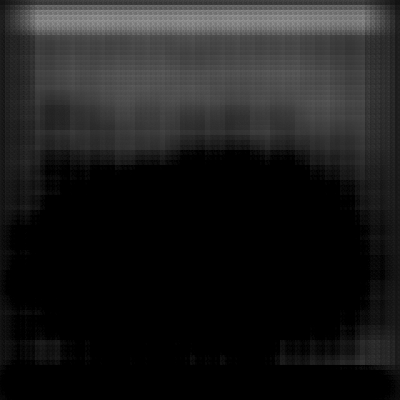

latent vector: tensor([-0.9603,  0.4085,  1.2125,  0.0033, -0.4313], device='cuda:0')
torch.Size([5])


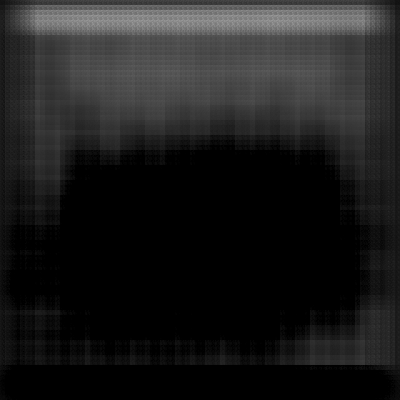

latent vector: tensor([-0.5540, -0.0329,  1.0418,  0.6310,  0.5521], device='cuda:0')
torch.Size([5])


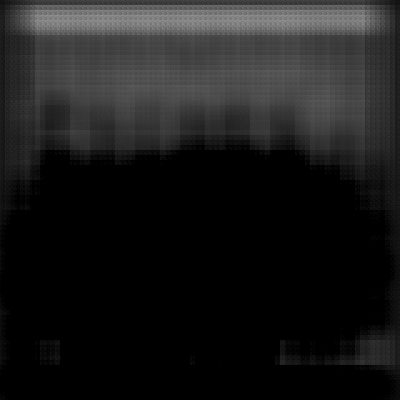

latent vector: tensor([-1.5477,  1.1813,  1.2749, -0.8695, -0.3243], device='cuda:0')
torch.Size([5])


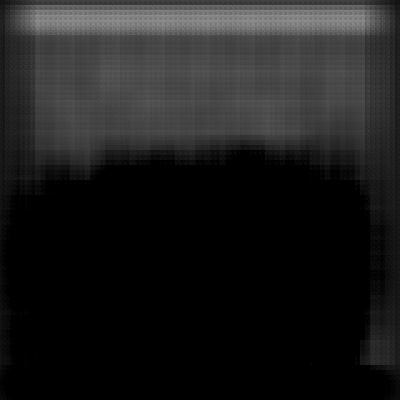

latent vector: tensor([-0.9913,  0.8934, -0.2588,  1.1475, -1.4054], device='cuda:0')
torch.Size([5])


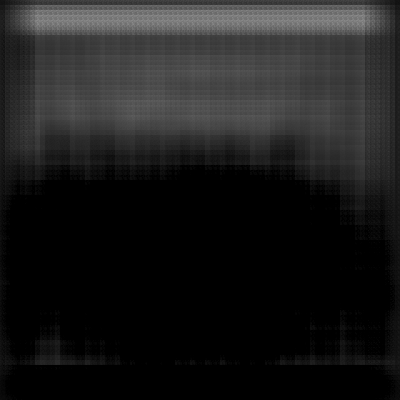

latent vector: tensor([ 0.1134,  0.4535, -1.1932, -0.9115,  0.0244], device='cuda:0')
torch.Size([5])


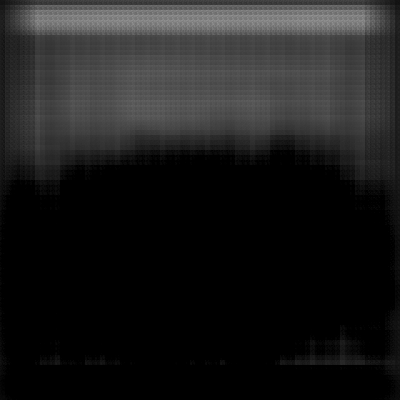

latent vector: tensor([-0.2709,  1.4118, -0.5337, -0.7211,  1.3046], device='cuda:0')
torch.Size([5])


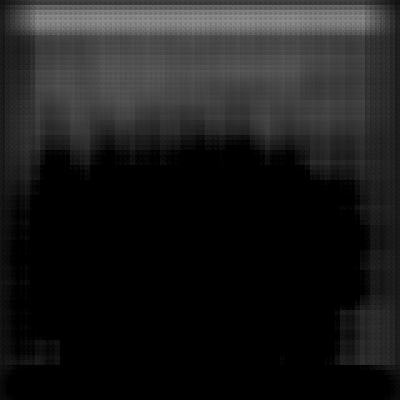

latent vector: tensor([-1.5747, -0.9051, -0.8216, -0.1022, -1.0270], device='cuda:0')
torch.Size([5])


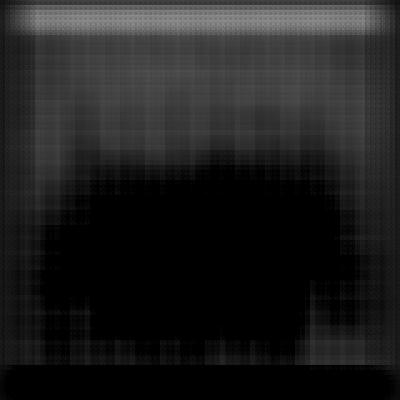

latent vector: tensor([ 0.7465, -0.0813,  0.5986,  0.1220, -0.2839], device='cuda:0')
torch.Size([5])


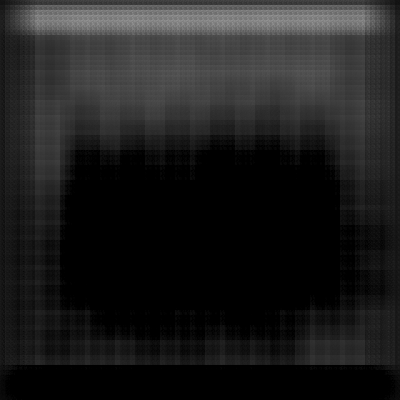

latent vector: tensor([-0.0203, -0.6351,  0.3745,  0.4987,  0.8113], device='cuda:0')
torch.Size([5])


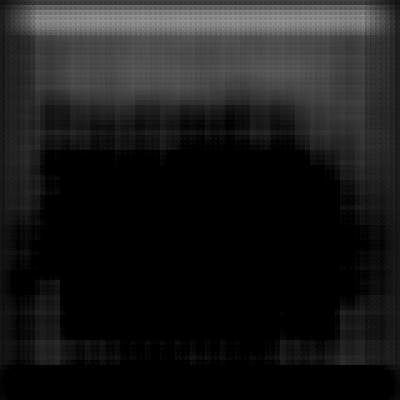

latent vector: tensor([-1.1808, -0.6910,  1.6287, -0.4619,  0.4588], device='cuda:0')
torch.Size([5])


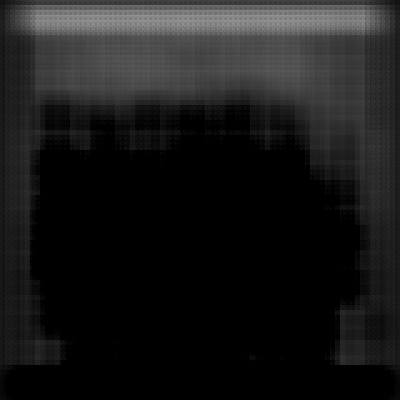

latent vector: tensor([-1.2560, -2.4124,  1.3903, -0.6020, -1.1195], device='cuda:0')
torch.Size([5])


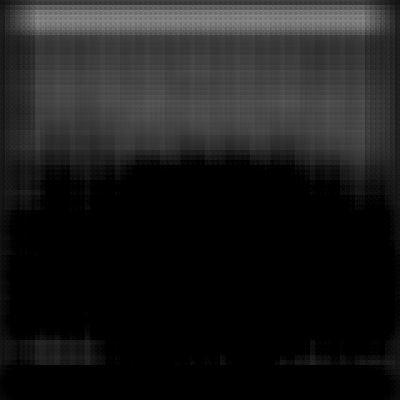

latent vector: tensor([ 0.8838,  1.2008, -0.2189, -1.4439, -0.9662], device='cuda:0')
torch.Size([5])


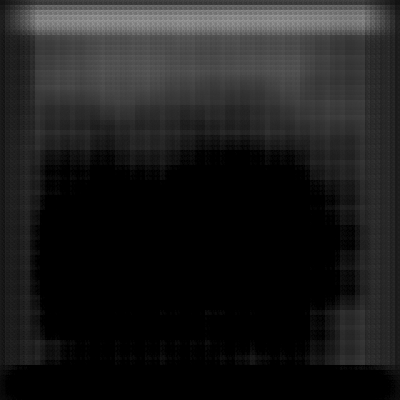

latent vector: tensor([-0.4035, -1.2911,  0.4258,  0.2629, -1.1173], device='cuda:0')


In [ ]:
vanGogh.generate_images(15, color=True, norm = True)

# VAE kleiner als 400 x 400 
Weil 400 x 400 sowohl für Grafikkarrte, als auch für Rekonstruktion absolut überambitioniert ist!

Ansonsten kann auch überlegt werden die Embeddinggröße zu vergrößern, um Ergebnisse zu verbessern.

In [ ]:
h,w = 64,64

class VAEsmall_color(nn.Module):

    def __init__(self, emb_size = 6):
        super(VAEsmall_color, self).__init__()
        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=4, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 6, stride = 1)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=4, stride=2)
        if emb_size == 6:
        elif emb_size == 
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=6, dilation=3, stride=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,10, kernel_size=4, dilation=1, stride=3)
        self.cnn3_decode = nn.ConvTranspose2d(10,1, kernel_size=40, dilation=1, stride=5)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn3_decode(x))
        else:
            x = F.relu(self.cnn3_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

# Anhang

In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
print(artists)

images_list = list()
for i, image in tqdm(enumerate(images)):
    img_path = os.path.join(path, image)
    #img = mpimg.imread(img_path)

    #bilder grau einlesen
    img = cv2.imread(img_path, 1)
    #bilder auf einheitliche größe bringen
    img = cv2.resize(img, (400,400))
    #bilder abzeigen (enabled)
    #cv2_imshow(img)
    #img_grey = rgb2gray(img)
    images_list.append(img)
    #plt.imshow(img)
    #if i == 5:
    #    break
len(images_list)

['Vincent_van_Gogh', 'Andy_Warhol', 'Pieter_Bruegel']


NameError: ignored

In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD